In [1]:
# Import relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import emoji as em
import regex as  re
import itertools
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation 
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# Imports the data and separates it into its dependent and independent variables
sad=pd.read_excel('SADdata.xlsx')
sad['Reaction'] = sad.apply(lambda x: round((x['Likes'] + x['Comments'])/2), axis=1)
sad['Class'] = pd.qcut(sad['Reaction'], 2, labels=['Not Popular', 'Popular'])
#sad['Class'] = np.where(sad['Reaction'] >= round(np.mean(sad['Reaction'])), 'Popular', 'Not Popular')
sad.head()

,Name,Gender,Age,height,Ethnicity,Opener,Pros,Cons,Likes,Comments,Reaction,Class
0,Scott Miketa,Male,22,70,Japanese,🍆 ATTENTION MEN OF SAD!!!!! 🍆 If you like your...,🍆He likes to go out and party🍾🍾🍾🍾\n🍆 He has be...,🧟‍♂️Can’t study for more than 10 minutes witho...,657,828,742,Popular
1,Dana Wu,Female,21,64,Chinese,🚨🚨🚨ATTENTION NYC HOTTIES🚨🚨🚨\nLOOKING👀👀👀👀 FOR A...,SECRETARY FOR VSA SO SHE SOCIAL AF\n- CUTE AF\...,WILL NEVER LOOK AS CUTE AS HER\n-WILL BARELY B...,2125,1681,1903,Popular
2,Stephanie Pham,Female,24,64,Vietnamese,"🔥🔥🔥OKAY LADIES AND GENTS, FEAST YOUR EYES ON T...","She's a pharmacist (smart cookie 🍪, and loaded...","This pharmacist can vaccinate, mess with her a...",2975,2667,2821,Popular
3,Niki,Female,26,62,Vietnamese,🌟🌟🌟 ATTENTION EVERYONE 🌟🌟🌟\nY’all need to star...,❗️she knows how to cook\n\n❗️will quote new gi...,❌ hard to deal with - anxiety induced mood swi...,414,352,383,Not Popular
4,Michael Xiao,Male,20,75,Chinese,ARE YOU A ♥WOMAN ♥ WHO IS LIVING WITH THOSE DO...,🔺This tall glass 🥂 of Chinese lovin 💕 spent la...,🔻He is 😇WHOLESOME😇 but gives off fuckboi vibes...,185,178,182,Not Popular


Text(0.5, 0, 'Age')

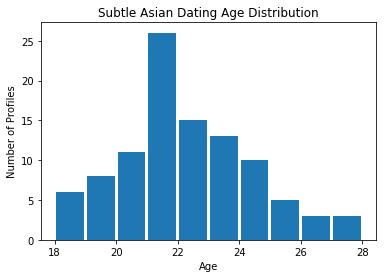

In [3]:
sad['Age'].plot.hist(bins = 10, rwidth = 0.9)
plt.title('Subtle Asian Dating Age Distribution')
plt.ylabel('Number of Profiles')
plt.xlabel('Age')

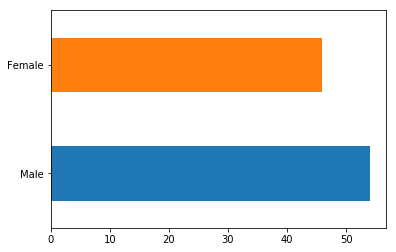

In [4]:
sad['Gender'].value_counts().plot('barh')

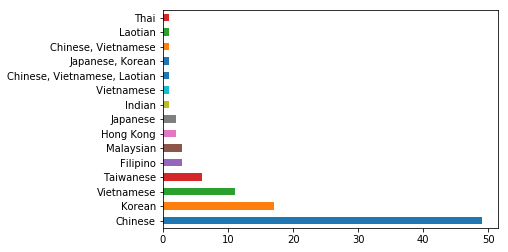

In [5]:
sad['Ethnicity'].value_counts().plot('barh')

Text(0.5, 0, 'Height in Inches')

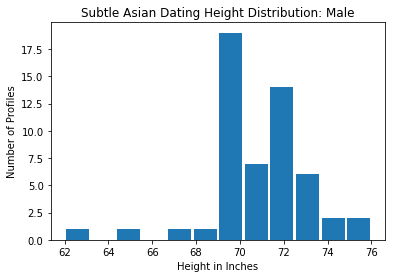

In [6]:
sad['height'][sad.Gender == 'Male'].plot.hist(bins = 12, rwidth = 0.9)
plt.title('Subtle Asian Dating Height Distribution: Male')
plt.ylabel('Number of Profiles')
plt.xlabel('Height in Inches')

Text(0.5, 0, 'Height in Inches')

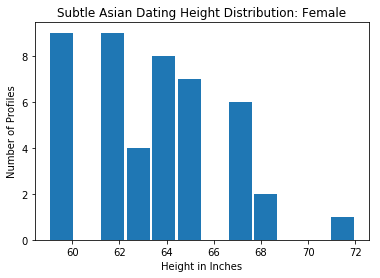

In [7]:
sad['height'][sad.Gender == 'Female'].plot.hist(bins = 12, rwidth = 0.9)
plt.title('Subtle Asian Dating Height Distribution: Female')
plt.ylabel('Number of Profiles')
plt.xlabel('Height in Inches')

Text(0.5, 0, 'Reaction Score')

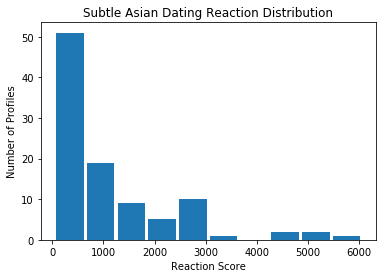

In [8]:
sad['Reaction'].plot.hist(bins = 10, rwidth = 0.9)
plt.title('Subtle Asian Dating Reaction Distribution')
plt.ylabel('Number of Profiles')
plt.xlabel('Reaction Score')

In [9]:
# some rudimentary data cleaning
sad['Opener'] = sad['Opener'].str.replace('-',"")
sad['Pros'] = sad['Pros'].str.replace('-',"")
sad['Cons'] = sad['Cons'].str.replace('-',"")
sad['Opener'] = sad['Opener'].str.replace('\n'," ")
sad['Pros'] = sad['Pros'].str.replace('\n'," ")
sad['Cons'] = sad['Cons'].str.replace('\n'," ")

In [10]:
# Define a function to move emojis into a separate list
def split_count(text):

    emoji_list = []
    data = re.findall(r'\X', text)
    flags = re.findall(u'[\U0001F1E6-\U0001F1FF]', text) 
    for word in data:
        if any(char in em.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list + flags

In [11]:
emojis_opener = [x for x in sad['Opener'].apply(split_count).tolist() if x != []]
emojis_opener = list(itertools.chain(*emojis_opener))
emojis_pros = [x for x in sad['Pros'].apply(split_count).tolist() if x != []]
emojis_pros = list(itertools.chain(*emojis_pros))
emojis_cons = [x for x in sad['Cons'].apply(split_count).tolist() if x != []]
emojis_cons = list(itertools.chain(*emojis_cons))

In [12]:
c = Counter(emojis_opener).most_common()[:10]
pd.DataFrame(c, columns = ['Emoji: Openers', 'Count'])

,Emoji: Openers,Count
0,🔥,68
1,‼️,66
2,🚨,57
3,📣,34
4,💦,30
5,❗️,27
6,⚠️,20
7,💥,20
8,👀,19
9,😱,18


In [13]:
emojis_opener = [x for x in sad['Opener'][sad['Class'] == 'Popular'].apply(split_count).tolist() if x != []]
emojis_opener = list(itertools.chain(*emojis_opener))
c = Counter(emojis_opener).most_common()[:10]
pd.DataFrame(c, columns = ['Emoji: Openers', 'Count'])

,Emoji: Openers,Count
0,🚨,35
1,📣,32
2,🔥,29
3,‼️,27
4,😵,17
5,👀,13
6,⚠️,10
7,❗️,9
8,💦,8
9,🌟,8


In [14]:
c = Counter(emojis_pros).most_common()[:10]
pd.DataFrame(c, columns = ['Emoji: Pros', 'Count'])

,Emoji: Pros,Count
0,✅,76
1,😉,55
2,🍆,47
3,💦,47
4,💸,45
5,➕,45
6,✔️,40
7,❣️,39
8,😍,34
9,❤️,31


In [15]:
emojis_pros = [x for x in sad['Pros'][sad['Class'] == 'Popular'].apply(split_count).tolist() if x != []]
emojis_pros = list(itertools.chain(*emojis_pros))
c = Counter(emojis_pros).most_common()[:10]
pd.DataFrame(c, columns = ['Emoji: Pros', 'Count'])

,Emoji: Pros,Count
0,✅,57
1,😉,42
2,❣️,30
3,💦,27
4,🍆,25
5,💸,24
6,✔,18
7,❤️,17
8,😍,14
9,👅,12


In [16]:
c = Counter(emojis_cons).most_common()[:10]
pd.DataFrame(c, columns = ['Emoji: Cons', 'Count'])

,Emoji: Cons,Count
0,❌,79
1,➖,25
2,😏,15
3,🚫,14
4,💩,14
5,☄️,14
6,💯,13
7,⚠️,13
8,🍆,12
9,🤦🏻‍♀️,11


In [17]:
emojis_cons = [x for x in sad['Cons'][sad['Class'] == 'Popular'].apply(split_count).tolist() if x != []]
emojis_cons = list(itertools.chain(*emojis_cons))
c = Counter(emojis_cons).most_common()[:10]
pd.DataFrame(c, columns = ['Emoji: Cons', 'Count'])

,Emoji: Cons,Count
0,❌,47
1,⚠️,13
2,🤦🏻‍♀️,10
3,🧟‍♂️,9
4,❣️,9
5,🤷🏻‍♀️,8
6,💯,8
7,🙊,7
8,✖,7
9,🤪,6


In [18]:
sad['Opener'] = sad['Opener'].str.replace("[^\w\s'`]",'')
sad['Pros'] = sad['Pros'].str.replace("[^\w\s'`]",'')
sad['Cons'] = sad['Cons'].str.replace("[^\w\s'`]",'')
sad.head()

,Name,Gender,Age,height,Ethnicity,Opener,Pros,Cons,Likes,Comments,Reaction,Class
0,Scott Miketa,Male,22,70,Japanese,ATTENTION MEN OF SAD If you like your men ha...,He likes to go out and party He has been on m...,Cant study for more than 10 minutes without ge...,657,828,742,Popular
1,Dana Wu,Female,21,64,Chinese,ATTENTION NYC HOTTIES LOOKING FOR A CUTE ASS W...,SECRETARY FOR VSA SO SHE SOCIAL AF CUTE AF BI...,WILL NEVER LOOK AS CUTE AS HER WILL BARELY BEA...,2125,1681,1903,Popular
2,Stephanie Pham,Female,24,64,Vietnamese,OKAY LADIES AND GENTS FEAST YOUR EYES ON THE W...,She's a pharmacist smart cookie and loaded y...,This pharmacist can vaccinate mess with her an...,2975,2667,2821,Popular
3,Niki,Female,26,62,Vietnamese,ATTENTION EVERYONE Yall need to start being ...,she knows how to cook will quote new girl and...,hard to deal with anxiety induced mood swing...,414,352,383,Not Popular
4,Michael Xiao,Male,20,75,Chinese,ARE YOU A WOMAN WHO IS LIVING WITH THOSE DOUB...,This tall glass of Chinese lovin spent last ...,He is WHOLESOME but gives off fuckboi vibes ju...,185,178,182,Not Popular


In [19]:

# Run the demojize which turns unicode emojis into their names
#sad['Opener'] = sad['Opener'].apply(em.demojize)
#sad['Pros'] = sad['Pros'].apply(em.demojize)
#sad['Cons'] = sad['Cons'].apply(em.demojize)
#sad.head()


# LDA

In [20]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 20

In [62]:
# Expand the stop_word list by adding to the sklearn's built in one
more_stop_words = ['ll', 'www', 've', "im", "youre", 'youve', 
                   'shes', 'aint', 'dont', 'hes', 'wont', 'ur', 
                   'yall', 'cant', 'doesn', 'doesnt', 'youll',
                  'shell', 'hell', 'joshua', 'chang', 'yu', 'ill',
                  'jonny', 'nick', 'thats', 'theres', 'was', 'got',
                  'wholl', 'gets', 'yo', 'https', 'com', 'know', 'asian',
                  'wayne', 'andrew']
from sklearn.feature_extraction import text 
stop_words = text.ENGLISH_STOP_WORDS.union(more_stop_words)

# Vectorizing for LDA
tf_vectorizer = CountVectorizer(min_df=2, lowercase = True, stop_words = stop_words, ngram_range=(1,3))
intro = tf_vectorizer.fit_transform(sad['Opener'][(sad['Gender'] == 'Male') & (sad['Class'] == 'Popular')])
intro_feature_names = tf_vectorizer.get_feature_names()
pros = tf_vectorizer.fit_transform(sad['Pros'][(sad['Gender'] == 'Male') & (sad['Class'] == 'Popular')])
pros_feature_names = tf_vectorizer.get_feature_names()
cons = tf_vectorizer.fit_transform(sad['Cons'][(sad['Gender'] == 'Male') & (sad['Class'] == 'Popular')])
cons_feature_names = tf_vectorizer.get_feature_names()

In [63]:
no_topics = 3
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
lda_intro = lda.fit_transform(intro)
display_topics(lda, intro_feature_names, no_top_words)

Topic 0:
looking attention ladies man oppa need handsome wholesome new attention ladies life boi tired young korean like home make years 20
Topic 1:
like georgetown look university georgetown university looking single girls wasian georgetown university right buy drinks bachelor peter aka buy drinks year namjas right like like korean namjas namjas right old studying government journalism wasian georgetown
Topic 2:
boy hello heart come big ny york wanna girls attention studying friend young year 23 comfort white new york single sad share


In [64]:
no_topics = 8
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
lda_pros = lda.fit_transform(pros)
display_topics(lda, pros_feature_names, no_top_words)

Topic 0:
hair year 3rd high real eyes thing best dental game did hot beat went years didnt listen high school goes look
Topic 1:
knows good tall does smile dresses going loves tennis gentleman like really man famous meals love dad big dance family
Topic 2:
like time make ya knows loves japanese sure world mean voice french love person best hit english man gives countries
Topic 3:
af does needs mean school takes pics danke getting actually alcohol university shopping self cute conversation starter went looks league hella
Topic 4:
play knows computer make better piano plays use business finance meals btw likes cs trilingual english ig kpop songs humble anime songs
Topic 5:
good make actually years going heart sing fashion just world look school clubbing man korean better night kpop 10 english
Topic 6:
knows years way squash man club big natural born free make born family spent ksa timed spent years natural lessons typa smart 40 pro free squash
Topic 7:
man life family time loves wholesom

In [65]:
no_topics = 15
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
lda_cons = lda.fit_transform(cons)
display_topics(lda, cons_feature_names, no_top_words)

Topic 0:
waiting pictures looks drunk probably high heart handsome ugly girls lowkey chinese big competition getting little make league start listen
Topic 1:
younger sight gentle single fall eats romcoms outmeme listen prettier food salad rabbits friends bad romcoms outmeme rabbits better huge like girls league makes sucks
Topic 2:
squat chinese make tall food big enjoys bad romcoms rabbits ass boi just genuinely enjoys head body drunk went week salad rabbits ready bad romcoms really korean
Topic 3:
look just pretty makes big literally smaller photos stolen fall like body ugly head little mans salad enjoys bad romcoms leaving younger
Topic 4:
league hair time bad romcoms outmeme drink really korean ask pretty listen spends bad korean learning like like boba little free make boba genuinely enjoys waiting romcoms big
Topic 5:
salad korean learning like genuinely learning single korean boba genuinely really league boba genuinely enjoys week salad rabbits 511 week bad romcoms genuinely enj

In [66]:
# Vectorizing for LDA
tf_vectorizer = CountVectorizer(min_df=2, lowercase = True, stop_words = stop_words, ngram_range=(1,2))
intro = tf_vectorizer.fit_transform(sad['Opener'][(sad['Gender'] == 'Female') & (sad['Class'] == 'Popular')])
intro_feature_names = tf_vectorizer.get_feature_names()
pros = tf_vectorizer.fit_transform(sad['Pros'][(sad['Gender'] == 'Female') & (sad['Class'] == 'Popular')])
pros_feature_names = tf_vectorizer.get_feature_names()
cons = tf_vectorizer.fit_transform(sad['Cons'][(sad['Gender'] == 'Female') & (sad['Class'] == 'Popular')])
cons_feature_names = tf_vectorizer.get_feature_names()

In [67]:
no_topics = 3
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
lda_intro = lda.fit_transform(intro)
display_topics(lda, intro_feature_names, no_top_words)

Topic 0:
nyc wholesome girl cause cuff really season make attention need ass boys don calling want af 22 time bae cute
Topic 1:
time wholesome look sad looking friend attention girl little present make good time beautiful ya guy bois introducing really stop covered
Topic 2:
tag hot looking okay post bitch wholesome bay area area bad bitch don winter just originally friends love tag single year free lookin


In [68]:
no_topics = 8
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
lda_pros = lda.fit_transform(pros)
display_topics(lda, pros_feature_names, no_top_words)

Topic 0:
girl abg like better kpop bible girl ass heels make high want looks long things pass bible chinese student live 52
Topic 1:
gonna good pretty smart sense actually probs sweet guess type loves personality humor sense humor kpop game love meals lookin eater
Topic 2:
great super love like parents love cute girl parents knows anime explore things student chill meals sure way independent trilingual streets
Topic 3:
eat good want need loves gym great wholesome order amazing stay easy talk humor super face best sense model looks dance
Topic 4:
super anime hang girl good make wholesome high order looks real artsy draw probably sweetest like cultured knows hentai foods
Topic 5:
af kinda fun loves works brains better super cute famous knows time feel like bank guess feel tall lover loyal af club
Topic 6:
af eat loves anime love just talk low maintenance chill low dance like worry raves model strong likes game super gym
Topic 7:
family mandarin point piano english sweetest think play mee

In [70]:
no_topics = 15
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
lda_cons = lda.fit_transform(cons)
display_topics(lda, cons_feature_names, no_top_words)

Topic 0:
dms bc small 10 drink chopsticks drinking thing wonder fan pics gram free need week saying type speak loyal literally big
Topic 1:
eating cute shot wonder shot wonder pics free gram better likes good pics gram need make week love right pictures rave lol
Topic 2:
ass gotta free drink literally does dms week eating bc handle game 10 rave people guys pics better lift best
Topic 3:
lot guys competition shot dms likes funny good maybe ass just loyal love week lol pictures loves thing probably handle
Topic 4:
10 cute chinese just fan guys best high type boba eating people love week time pictures looks pics gram probably shot wonder
Topic 5:
chopsticks use chopsticks use chinese maybe league small pictures life really guys hoodies drinking love looks competition handle wonder loves right
Topic 6:
loyal probably guys ass like league maybe pictures drink good tell week use chopsticks high people handle rave big bc use
Topic 7:
ig make clout handle 10 high like bc week big game hoodies 

# SVM Classification

In [29]:
# Extract our values to train our SVM models
y=np.array(sad['Class'].values.tolist())
X_intro=sad['Opener'].values
X_pros=sad['Pros'].values
X_cons=sad['Cons'].values

unigram_tfidf = TfidfVectorizer(encoding='latin-1', use_idf=True, min_df = 2, stop_words = stop_words)
unigram_bigram_tfidf = TfidfVectorizer(encoding='latin-1', use_idf=True, min_df = 2, stop_words = stop_words, ngram_range=(1,3))

## SVM Classification - Openers

In [30]:
# Split Training and Testing Set
X_train, X_test, y_train, y_test = train_test_split(X_intro, y, test_size=0.4, random_state=0)

# Vectorizers the training set and testing set
X_train_unigram = unigram_tfidf.fit_transform(X_train)
X_train_unigram_bigram = unigram_bigram_tfidf.fit_transform(X_train)
print("Training set shape after vectorization: unigram")
print(X_train_unigram.shape)
print("Training set shape after vectorization: unigram & bigram")
print(X_train_unigram_bigram.shape)

X_test_unigram = unigram_tfidf.transform(X_test)
X_test_unigram_bigram = unigram_bigram_tfidf.transform(X_test)
print("Testing set shape after vectorization: unigram")
print(X_test_unigram.shape)
print("Testing set shape after vectorization: unigram & bigram")
print(X_test_unigram_bigram.shape)

Training set shape after vectorization: unigram
(60, 182)
Training set shape after vectorization: unigram & bigram
(60, 244)
Testing set shape after vectorization: unigram
(40, 182)
Testing set shape after vectorization: unigram & bigram
(40, 244)


In [31]:
# initialize the models
svm_clf_unigram = LinearSVC(C=0.8)

# use the training data to train the models
svm_clf_unigram.fit(X_train_unigram, y_train)

print("Unigram SVM confusion matrix and evaluation metrics")
print()
target_names = ['Not Popular', 'Popular']
y_pred = svm_clf_unigram.predict(X_test_unigram)
print(confusion_matrix(y_test, y_pred, labels=['Not Popular', 'Popular']))
print()
print(classification_report(y_test, y_pred, target_names=target_names))

Unigram SVM confusion matrix and evaluation metrics

[[10 12]
 [ 6 12]]

              precision    recall  f1-score   support

 Not Popular       0.62      0.45      0.53        22
     Popular       0.50      0.67      0.57        18

   micro avg       0.55      0.55      0.55        40
   macro avg       0.56      0.56      0.55        40
weighted avg       0.57      0.55      0.55        40



In [32]:
# Gets most informative features for SVM classifier
feature_ranks_svm_popular = sorted(zip(svm_clf_unigram.coef_[0], unigram_tfidf.get_feature_names()))
#feature_ranks_svm_popular = sorted(zip(svm_clf_unigram.coef_[1], unigram_tfidf.get_feature_names()))

not_popular_10 = feature_ranks_svm_popular[:10]
print("Not popular words: Unigram SVM")
for i in range(0, len(not_popular_10)):
    print(not_popular_10[i])
print()

popular_10 = feature_ranks_svm_popular[-10:]
print("Popular words: Unigram SVM")
for i in range(0, len(popular_10)):
    print(popular_10[i])
print()

Not popular words: Unigram SVM
(-0.8946426471609028, 'trying')
(-0.8543641502041024, 'wanted')
(-0.8051298868922938, 'ready')
(-0.7256913065367858, 'day')
(-0.7166426242023961, 'stop')
(-0.7070368414741994, 'real')
(-0.6888783642664924, 'hit')
(-0.6408138292536393, 'texas')
(-0.6373073470363939, 'present')
(-0.5398853804295767, 'date')

Popular words: Unigram SVM
(0.5290222270717391, 'boi')
(0.532043127427789, 'don')
(0.536203863153501, 'promote')
(0.5487272332466644, '22')
(0.553909973455104, 'auction')
(0.5569384725987088, 'east')
(0.5637625649202196, 'oppa')
(0.570980958814838, 'time')
(0.6775046841737385, 'handsome')
(0.9336244837235645, 'big')



In [33]:
# initialize the models
svm_clf_unigram_bigram = LinearSVC(C=1)

# use the training data to train the models
svm_clf_unigram_bigram.fit(X_train_unigram_bigram, y_train)

print("Unigram & Bigram SVM confusion matrix and evaluation metrics")
print()
target_names = ['Not Popular', 'Popular']
y_pred = svm_clf_unigram_bigram.predict(X_test_unigram_bigram)
print(confusion_matrix(y_test, y_pred, labels=['Not Popular', 'Popular']))
print()
print(classification_report(y_test, y_pred, target_names=target_names))

Unigram & Bigram SVM confusion matrix and evaluation metrics

[[10 12]
 [ 5 13]]

              precision    recall  f1-score   support

 Not Popular       0.67      0.45      0.54        22
     Popular       0.52      0.72      0.60        18

   micro avg       0.57      0.57      0.57        40
   macro avg       0.59      0.59      0.57        40
weighted avg       0.60      0.57      0.57        40



In [34]:
# Gets most informative features for SVM classifier
feature_ranks_svm_popular = sorted(zip(svm_clf_unigram_bigram.coef_[0], unigram_tfidf.get_feature_names()))

not_popular_10 = feature_ranks_svm_popular[:10]
print("Not popular words: Unigram & Bigram SVM")
for i in range(0, len(not_popular_10)):
    print(not_popular_10[i])
print()

popular_10 = feature_ranks_svm_popular[-10:]
print("Popular words: Unigram & Bigram SVM")
for i in range(0, len(popular_10)):
    print(popular_10[i])
print()

Not popular words: Unigram & Bigram SVM
(-0.7407742596038009, 'girl')
(-0.7406014897500506, 'make')
(-0.728629123874438, 'world')
(-0.7208393779701251, 'winter')
(-0.6639024891229653, 'knows')
(-0.5383900186106961, 'vancouver')
(-0.5336406414828545, 'chinese')
(-0.5015798831287109, 'don')
(-0.49147242629699295, 'highly')
(-0.49147242629699295, 'material')

Popular words: Unigram & Bigram SVM
(0.49452927388859, 'men')
(0.5486756095514336, 'handsome')
(0.5561668161547403, '22')
(0.567696151430889, 'guy')
(0.5806869590388313, 'year')
(0.58612537720236, 'wants')
(0.609856070189694, 'beautiful')
(0.615420089255114, 'time')
(0.6890614541062804, 'life')
(1.0022614033822106, 'brains')



## SVM Classification - Pros

In [35]:
# Split Training and Testing Set
X_train, X_test, y_train, y_test = train_test_split(X_pros, y, test_size=0.4, random_state=0)

# Vectorizers the training set and testing set
X_train_unigram = unigram_tfidf.fit_transform(X_train)
X_train_unigram_bigram = unigram_bigram_tfidf.fit_transform(X_train)
print("Training set shape after vectorization: unigram")
print(X_train_unigram.shape)
print("Training set shape after vectorization: unigram & bigram")
print(X_train_unigram_bigram.shape)

X_test_unigram = unigram_tfidf.transform(X_test)
X_test_unigram_bigram = unigram_bigram_tfidf.transform(X_test)
print("Testing set shape after vectorization: unigram")
print(X_test_unigram.shape)
print("Testing set shape after vectorization: unigram & bigram")
print(X_test_unigram_bigram.shape)

Training set shape after vectorization: unigram
(60, 568)
Training set shape after vectorization: unigram & bigram
(60, 841)
Testing set shape after vectorization: unigram
(40, 568)
Testing set shape after vectorization: unigram & bigram
(40, 841)


In [36]:
# initialize the models
svm_clf_unigram = LinearSVC(C=0.8)

# use the training data to train the models
svm_clf_unigram.fit(X_train_unigram, y_train)

print("Unigram SVM confusion matrix and evaluation metrics")
print()
target_names = ['Not Popular', 'Popular']
y_pred = svm_clf_unigram.predict(X_test_unigram)
print(confusion_matrix(y_test, y_pred, labels=['Not Popular', 'Popular']))
print()
print(classification_report(y_test, y_pred, target_names=target_names))

Unigram SVM confusion matrix and evaluation metrics

[[ 6 16]
 [ 6 12]]

              precision    recall  f1-score   support

 Not Popular       0.50      0.27      0.35        22
     Popular       0.43      0.67      0.52        18

   micro avg       0.45      0.45      0.45        40
   macro avg       0.46      0.47      0.44        40
weighted avg       0.47      0.45      0.43        40



In [37]:
# Gets most informative features for SVM classifier
feature_ranks_svm_popular = sorted(zip(svm_clf_unigram.coef_[0], unigram_tfidf.get_feature_names()))
#feature_ranks_svm_popular = sorted(zip(svm_clf_unigram.coef_[1], unigram_tfidf.get_feature_names()))

not_popular_10 = feature_ranks_svm_popular[:10]
print("Not popular words: Unigram SVM")
for i in range(0, len(not_popular_10)):
    print(not_popular_10[i])
print()

popular_10 = feature_ranks_svm_popular[-10:]
print("Popular words: Unigram SVM")
for i in range(0, len(popular_10)):
    print(popular_10[i])
print()

Not popular words: Unigram SVM
(-0.5990872571856678, 'want')
(-0.5496172243755115, 'right')
(-0.48644559424945066, 'currently')
(-0.4726581316061128, 'like')
(-0.47045417996910216, 'key')
(-0.45649702312531637, 'basically')
(-0.45254187556860037, 'program')
(-0.4478966938350781, 'bc')
(-0.4474494387047489, 'life')
(-0.4409534829873429, 'plays')

Popular words: Unigram SVM
(0.45636689386495033, 'world')
(0.45853770551382617, 'drink')
(0.4607837279185171, 'years')
(0.46738489419751367, 'kinda')
(0.47022869728055144, 'professional')
(0.472533260088293, 'anime')
(0.5276967455454742, 'gym')
(0.5505787360519167, 'knows')
(0.5774767916355168, 'time')
(0.6825714568323872, 'better')



In [38]:
# initialize the models
svm_clf_unigram_bigram = LinearSVC(C=1.5)

# use the training data to train the models
svm_clf_unigram_bigram.fit(X_train_unigram_bigram, y_train)

print("Unigram & Bigram SVM confusion matrix and evaluation metrics")
print()
target_names = ['Not Popular', 'Popular']
y_pred = svm_clf_unigram_bigram.predict(X_test_unigram_bigram)
print(confusion_matrix(y_test, y_pred, labels=['Not Popular', 'Popular']))
print()
print(classification_report(y_test, y_pred, target_names=target_names))

Unigram & Bigram SVM confusion matrix and evaluation metrics

[[ 7 15]
 [ 5 13]]

              precision    recall  f1-score   support

 Not Popular       0.58      0.32      0.41        22
     Popular       0.46      0.72      0.57        18

   micro avg       0.50      0.50      0.50        40
   macro avg       0.52      0.52      0.49        40
weighted avg       0.53      0.50      0.48        40



In [39]:
# Gets most informative features for SVM classifier
feature_ranks_svm_popular = sorted(zip(svm_clf_unigram_bigram.coef_[0], unigram_tfidf.get_feature_names()))

not_popular_10 = feature_ranks_svm_popular[:10]
print("Not popular words: Unigram & Bigram SVM")
for i in range(0, len(not_popular_10)):
    print(not_popular_10[i])
print()

popular_10 = feature_ranks_svm_popular[-10:]
print("Popular words: Unigram & Bigram SVM")
for i in range(0, len(popular_10)):
    print(popular_10[i])
print()

Not popular words: Unigram & Bigram SVM
(-0.5953725805662857, 'faves')
(-0.5752508754492847, 'quite')
(-0.5460310166980874, 'bread')
(-0.5441648366534317, 'school')
(-0.5060471356953041, 'second')
(-0.48959057843766685, 'photos')
(-0.48584610966546093, 'singer')
(-0.4801601559658405, 'touch')
(-0.44364631788754233, 'body')
(-0.4208936381284694, 'day')

Popular words: Unigram & Bigram SVM
(0.464386899839497, 'huge')
(0.4709381041669718, 'durian')
(0.49784691331341124, 'places')
(0.504177221661561, 'hit')
(0.5568953031747167, 'athletic')
(0.5573360210186775, 'girls')
(0.5766649735255454, 'read')
(0.6449739475477929, 'mom')
(0.7029930367443964, 'ready')
(0.8294408117057371, 'bubble')



## SVM Classification - Cons

In [40]:
# Split Training and Testing Set
X_train, X_test, y_train, y_test = train_test_split(X_cons, y, test_size=0.4, random_state=0)

# Vectorizers the training set and testing set
X_train_unigram = unigram_tfidf.fit_transform(X_train)
X_train_unigram_bigram = unigram_bigram_tfidf.fit_transform(X_train)
print("Training set shape after vectorization: unigram")
print(X_train_unigram.shape)
print("Training set shape after vectorization: unigram & bigram")
print(X_train_unigram_bigram.shape)

X_test_unigram = unigram_tfidf.transform(X_test)
X_test_unigram_bigram = unigram_bigram_tfidf.transform(X_test)
print("Testing set shape after vectorization: unigram")
print(X_test_unigram.shape)
print("Testing set shape after vectorization: unigram & bigram")
print(X_test_unigram_bigram.shape)

Training set shape after vectorization: unigram
(60, 249)
Training set shape after vectorization: unigram & bigram
(60, 360)
Testing set shape after vectorization: unigram
(40, 249)
Testing set shape after vectorization: unigram & bigram
(40, 360)


In [41]:
# initialize the models
svm_clf_unigram = LinearSVC(C=1.5)

# use the training data to train the models
svm_clf_unigram.fit(X_train_unigram, y_train)

print("Unigram SVM confusion matrix and evaluation metrics")
print()
target_names = ['Not Popular', 'Popular']
y_pred = svm_clf_unigram.predict(X_test_unigram)
print(confusion_matrix(y_test, y_pred, labels=['Not Popular', 'Popular']))
print()
print(classification_report(y_test, y_pred, target_names=target_names))

Unigram SVM confusion matrix and evaluation metrics

[[11 11]
 [11  7]]

              precision    recall  f1-score   support

 Not Popular       0.50      0.50      0.50        22
     Popular       0.39      0.39      0.39        18

   micro avg       0.45      0.45      0.45        40
   macro avg       0.44      0.44      0.44        40
weighted avg       0.45      0.45      0.45        40



In [42]:
# Gets most informative features for SVM classifier
feature_ranks_svm_popular = sorted(zip(svm_clf_unigram.coef_[0], unigram_tfidf.get_feature_names()))
#feature_ranks_svm_popular = sorted(zip(svm_clf_unigram.coef_[1], unigram_tfidf.get_feature_names()))

not_popular_10 = feature_ranks_svm_popular[:10]
print("Not popular words: Unigram SVM")
for i in range(0, len(not_popular_10)):
    print(not_popular_10[i])
print()

popular_10 = feature_ranks_svm_popular[-10:]
print("Popular words: Unigram SVM")
for i in range(0, len(popular_10)):
    print(popular_10[i])
print()

Not popular words: Unigram SVM
(-1.0593295020347688, 'boba')
(-0.8766049163239443, 'super')
(-0.8688950804265847, 'gotta')
(-0.7718399894423585, 'random')
(-0.7412746984027907, 'cantonese')
(-0.7225508047137107, 'takes')
(-0.7176586393081539, 'af')
(-0.7104634422353717, 'especially')
(-0.706957757418703, 'glow')
(-0.6702195865866608, 'snatch')

Popular words: Unigram SVM
(0.5646274435703429, 'allergies')
(0.5999660203016712, 'short')
(0.6055572848243427, 'probably')
(0.643397433751922, 'girl')
(0.659675908363225, 'beat')
(0.6926125767655144, 'girls')
(0.7376121736745427, 'single')
(0.7852461182436858, 'literally')
(0.8461072168476137, 'look')
(0.8877790559987397, 'league')



In [43]:
# initialize the models
svm_clf_unigram_bigram = LinearSVC(C=2)

# use the training data to train the models
svm_clf_unigram_bigram.fit(X_train_unigram_bigram, y_train)

print("Unigram & Bigram SVM confusion matrix and evaluation metrics")
print()
target_names = ['Not Popular', 'Popular']
y_pred = svm_clf_unigram_bigram.predict(X_test_unigram_bigram)
print(confusion_matrix(y_test, y_pred, labels=['Not Popular', 'Popular']))
print()
print(classification_report(y_test, y_pred, target_names=target_names))

Unigram & Bigram SVM confusion matrix and evaluation metrics

[[10 12]
 [11  7]]

              precision    recall  f1-score   support

 Not Popular       0.48      0.45      0.47        22
     Popular       0.37      0.39      0.38        18

   micro avg       0.42      0.42      0.42        40
   macro avg       0.42      0.42      0.42        40
weighted avg       0.43      0.42      0.43        40



In [44]:
# Gets most informative features for SVM classifier
feature_ranks_svm_popular = sorted(zip(svm_clf_unigram_bigram.coef_[0], unigram_tfidf.get_feature_names()))

not_popular_10 = feature_ranks_svm_popular[:10]
print("Not popular words: Unigram & Bigram SVM")
for i in range(0, len(not_popular_10)):
    print(not_popular_10[i])
print()

popular_10 = feature_ranks_svm_popular[-10:]
print("Popular words: Unigram & Bigram SVM")
for i in range(0, len(popular_10)):
    print(popular_10[i])
print()

Not popular words: Unigram & Bigram SVM
(-1.121766278820855, 'close')
(-0.8934625641294013, 'male')
(-0.8151669642504102, 'count')
(-0.7935146029636427, 'attention')
(-0.702749543728938, 'guy')
(-0.6902804582494506, 'lowkey')
(-0.6502584839039247, 'career')
(-0.6501023900989541, 'making')
(-0.6230268929917465, 'free')
(-0.5846191472651665, 'short')

Popular words: Unigram & Bigram SVM
(0.6069772400162016, 'look')
(0.6180441762022562, 'bachelor')
(0.6546994475697617, 'truly')
(0.6875147541420416, 'whitewashed')
(0.6879444177510083, 'love')
(0.7197413926766589, 'cantonese')
(0.7411852419045829, 'loves')
(0.8342152714186158, 'shot')
(0.8689878356865463, 'school')
(0.9270563648119666, 'quick')

